In [1]:
#Problem statment : Build a classifer that can predict if claimant will hire an attorney or not

import pandas as pd
import matplotlib.pyplot as plot
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [24]:
#Read dataset and load it into a dataframe
data = pd.read_csv("A:\dataset\compworker\Assembled_Workers__Compensation_Claims___Beginning_2000.csv")
data.shape

(3257907, 51)

In [5]:
#Print all the attributes, this helps us to get a feel for what unimportnat attributes are ex: claim identifier is just ID
data.columns

Index(['Claim Identifier', 'Claim Type', 'District Name',
       'Average Weekly Wage', 'Current Claim Status', 'Claim Injury Type',
       'Age at Injury', 'Assembly Date', 'Accident Date', 'ANCR Date',
       'Controverted Date', 'Section 32 Date', 'PPD Scheduled Loss Date',
       'PPD Non-Scheduled Loss Date', 'PTD Date', 'First Appeal Date',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'OIICS Part Of Body Code', 'OIICS Part Of Body Description',
       'OIICS Nature of Injury Code', 'OIICS Nature of Injury Description',
       'OIICS Injury Source Code', 'OIICS Injury Source Description',
       'OIICS Event Exposure Code', 'OIICS Event Exposure Description',
       'OIICS Secondary Source Code', 'OIICS Secondary Source Description',
       'Alternative Dispute Resolution', 'Gender', 'Birth Year', 'Zip Code',


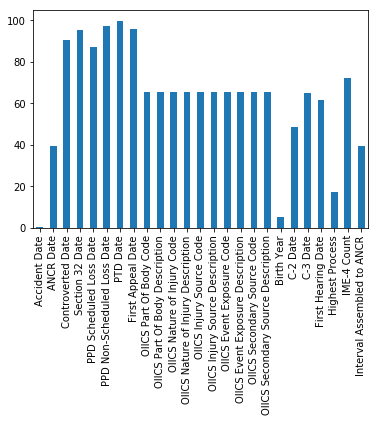

In [4]:
# Explore data
perecent_missing = (data.isnull().sum()/data.shape[0])*100
#perecent_missing
perecent_missing[perecent_missing>0].plot(kind='bar')

#precent_missing.plot(kind = 'bar')
#we see columns with missing values are mostly date, except nature of body rest can be dropped because it is mostly date an event
# that might mostly have no bearing on hiring an attorney

In [5]:
attributes = perecent_missing[perecent_missing == 0.0]
attributes
#We see we have 26 attributes without missing values, also it looks like we have attributes that may off set
#"part of body descrition" 

Claim Identifier                     0.0
Claim Type                           0.0
District Name                        0.0
Average Weekly Wage                  0.0
Current Claim Status                 0.0
Claim Injury Type                    0.0
Age at Injury                        0.0
Assembly Date                        0.0
WCIO Part Of Body Code               0.0
WCIO Part Of Body Description        0.0
WCIO Nature of Injury Code           0.0
WCIO Nature of Injury Description    0.0
WCIO Cause of Injury Code            0.0
WCIO Cause of Injury Description     0.0
Alternative Dispute Resolution       0.0
Gender                               0.0
Zip Code                             0.0
Medical Fee Region                   0.0
Hearing Count                        0.0
Closed Count                         0.0
Attorney/Representative              0.0
Carrier Name                         0.0
Carrier Type                         0.0
Accident                             0.0
Occupational Dis

In [9]:
data['Accident'].value_counts()/data['Accident'].shape[0] * 100
#this is interesting some injuries were not accident? We will have to look into this further we may uncover something intersting

Y    98.145067
N     1.854933
Name: Accident, dtype: float64

In [11]:
# Let's now build our model, beofre that let's see what the distribution of our target variable is like
data['Attorney/Representative'].value_counts()/data['Attorney/Representative'].shape[0]*100
# This is now evenly distributed! We will use precsion, recall and F1 score as our performance metrics

N    67.716942
Y    32.283058
Name: Attorney/Representative, dtype: float64

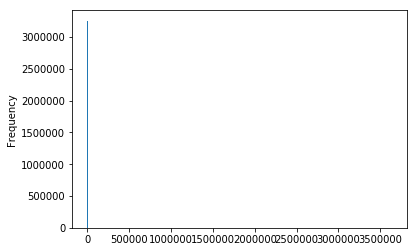

In [58]:
#Before that let's clean our data set
#We use 26 attribtues and we will convert them into categorical vairable
#we won't use dummy variable becauase there will be attribute explosion 
(data['Average Weekly Wage'].replace('\$','',regex = True).astype(float)).plot(kind = 'hist', bins = 1000)

#replcae $ with number

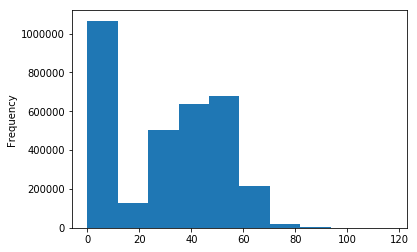

In [17]:
data['Age at Injury'].plot(kind='hist')

In [39]:
#data[data['Age at Injury'] >= 80 & data['Age at Injury'] < 16].sum()

sum(data['Age at Injury'] >80)
#2896
sum(data['Age at Injury'] <16)
# this doesn't look right! we can't drop rows containing age because we will lose lot of info,we will just drop the colum

1066860

In [59]:
data['County of Injury'].value_counts().head(10)

NEW YORK       321606
QUEENS         298281
SUFFOLK        287631
KINGS          263093
NASSAU         219034
ERIE           200803
BRONX          177248
MONROE         145959
WESTCHESTER    138545
ONONDAGA       103178
Name: County of Injury, dtype: int64

In [7]:
categorical_col = data[['Claim Type', 'District Name', 'Claim Injury Type', 'WCIO Part Of Body Code', 
                       'WCIO Nature of Injury Code', 'Alternative Dispute Resolution', 'Gender',
                       'Medical Fee Region', 'Hearing Count', 'Carrier Type', 'Occupational Disease',
                        'County of Injury','Attorney/Representative' ]]
for col in categorical_col:
            b, c = np.unique(data[col], return_inverse=True)
            categorical_col[col] = c
categorical_col.head(10)

,Claim Type,District Name,Claim Injury Type,WCIO Part Of Body Code,WCIO Nature of Injury Code,Alternative Dispute Resolution,Gender,Medical Fee Region,Hearing Count,Carrier Type,Occupational Disease,County of Injury,Attorney/Representative
0,3,5,3,56,54,0,0,3,0,3,0,23,0
1,3,5,3,56,54,0,1,3,4,9,0,2,1
2,3,5,3,56,54,0,1,3,0,3,0,23,0
3,3,2,8,24,18,0,1,0,0,0,0,14,0
4,3,8,8,17,25,0,0,1,0,1,0,32,0
5,3,8,8,9,18,0,1,0,0,1,0,49,0
6,3,8,2,6,30,0,1,0,0,3,0,22,0
7,3,8,2,42,5,0,0,0,0,4,0,33,0
8,3,8,2,23,18,0,1,0,0,4,0,37,0
9,3,5,3,56,54,0,1,3,1,3,0,23,0


In [8]:
#Wohooo! We now build over classifer 

X = categorical_col.iloc[:,:-1]
y = categorical_col.iloc[:,-1]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [10]:
#param_grid = [{'n_estimators' : [100, 150, 75] }, 
 #            {'bootstrap':[False],'n_estimators': [100, 150] }]

In [11]:
clf = RandomForestClassifier(n_estimators= 50, min_samples_split= 10, criterion='gini')
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
importances = clf.feature_importances_
feature_importance = sorted(zip(importances, list(X_train)), reverse=True)
print (feature_importance)

[(0.65643995487338769, 'Hearing Count'), (0.19172822545119581, 'Claim Injury Type'), (0.030978198768095423, 'WCIO Part Of Body Code'), (0.024345244589241536, 'WCIO Nature of Injury Code'), (0.022708680231146042, 'County of Injury'), (0.016774530711084423, 'Carrier Type'), (0.016143583385303358, 'District Name'), (0.015601369012827488, 'Medical Fee Region'), (0.01189247036468343, 'Occupational Disease'), (0.0072245662130862353, 'Alternative Dispute Resolution'), (0.005032835419771271, 'Gender'), (0.0011303409801770492, 'Claim Type')]


In [20]:
y_pred = clf.predict(X_test)
print("F1 for Random Forest :" + str(f1_score(y_test, y_pred, average="macro")))
print("Precison for Random Forest :" + str(precision_score(y_test, y_pred, average="macro")))
print("Recall for Random Forest :" + str(recall_score(y_test, y_pred, average="macro"))  )

F1 for Random Forest :0.872128433232
Precison for Random Forest :0.882384192656
Recall for Random Forest :0.863887841493


In [21]:
logistic = linear_model.LogisticRegression()
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
print("F1 for Random Forest :" + str(f1_score(y_test, y_pred, average="macro")))
print("Precison for Random Forest :" + str(precision_score(y_test, y_pred, average="macro")))
print("Recall for Random Forest :" + str(recall_score(y_test, y_pred, average="macro"))  )

F1 for Random Forest :0.835595947498
Precison for Random Forest :0.871886312638
Recall for Random Forest :0.81587988341
